In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install -U keras-tuner

In [4]:
import argparse
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import layers, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.models import load_model, Model
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import kerastuner as kt
from kerastuner.tuners import RandomSearch
class_map = {'eagle': 0, 'panda': 1, 'polar-bear': 2}

# Učitavanje slika i oznaka
train_imgs = np.load('drive/MyDrive/cropped/train_imgs.npy')
train_labels = np.load('drive/MyDrive/cropped/train_labels.npy')
test_imgs = np.load('drive/MyDrive/cropped/test_imgs.npy')
test_labels = np.load('drive/MyDrive/cropped/test_labels.npy')
val_imgs = np.load('drive/MyDrive/cropped/val_imgs.npy')
val_labels = np.load('drive/MyDrive/cropped/val_labels.npy')

print(f"train_imgs shape: {train_imgs.shape}")
print(f"test_imgs shape: {test_imgs.shape}")
print(f"val_imgs shape: {val_imgs.shape}")


# Augmentacija slika
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,

)

# Kreiranje skupa podataka
train_set = train_datagen.flow(
    train_imgs,
    train_labels,
    batch_size=32,
    shuffle=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
)

val_set = val_datagen.flow(
    val_imgs,
    val_labels,
    batch_size=32,
    shuffle=False
)

train_imgs shape: (2459, 224, 224, 3)
test_imgs shape: (769, 224, 224, 3)
val_imgs shape: (615, 224, 224, 3)


In [2]:
import argparse
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import layers, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.models import load_model, Model
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import kerastuner as kt
from kerastuner.tuners import RandomSearch


def report_model(md, model_name, images, labels, classes):
    print("**********REPORT FOR ", model_name.upper(), " MODEL********** /n")
    predictions = md.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    report = classification_report(labels, predicted_labels, target_names=list(classes.keys()),
                                   labels=list(classes.values()))
    print(report)
    print("******************************************")

def build_model(hp):
    base_model = keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg'
    )

    num_frozen_layers = hp.Int('num_frozen_layers', min_value=50, max_value=310, step=10)

    # Fine-tuning
    for layer in base_model.layers[:num_frozen_layers]:
        layer.trainable = False
    for layer in base_model.layers[num_frozen_layers:]:
        layer.trainable = True

    x = base_model.output
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(hp.Int('units', min_value=700, max_value=2048, step=200), activation='relu')(x)
    if hp.Boolean("dropout"):
        x = keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.07, max_value=0.3, step=0.1))(x)

    predictions = keras.layers.Dense(3, activation='softmax')(x)

    model = keras.models.Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model






<ipython-input-2-b7f989354eab>:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [7]:
tuner = kt.RandomSearch(
      build_model,
      objective='val_loss',
      max_trials=5)

tuner.search(train_set, epochs=5, validation_data=val_set)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Ispis hiperparametara
print("Best Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

Trial 5 Complete [00h 05m 28s]
val_loss: 0.23547224700450897

Best val_loss So Far: 0.03883394971489906
Total elapsed time: 00h 23m 58s
Best Hyperparameters:
num_frozen_layers: 260
units: 1900
dropout: False
lr: 0.0008053532244671809
dropout_rate: 0.27


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 111, 111, 32)   │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 111, 111, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 109, 109, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 109, 109, 32)   │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 109, 109, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 109, 109, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 109, 109, 64)   │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 109, 109, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 54, 54, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 54, 54, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 54, 54, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 111, 111, 32)   │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 111, 111, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 109, 109, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 109, 109, 32)   │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 109, 109, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 109, 109, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 109, 109, 64)   │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 109, 109, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 54, 54, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 54, 54, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 54, 54, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 23,904,035 (91.19 MB)

 Trainable params: 2,101,251 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 63s 633ms/step - accuracy: 0.8118 - loss: 0.4897 - val_accuracy: 0.9756 - val_loss: 0.1153
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 494ms/step - accuracy: 0.9691 - loss: 0.1137 - val_accuracy: 0.9691 - val_loss: 0.1082
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 39s 463ms/step - accuracy: 0.9714 - loss: 0.0913 - val_accuracy: 0.9512 - val_loss: 0.1456
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 460ms/step - accuracy: 0.9707 - loss: 0.0783 - val_accuracy: 0.9691 - val_loss: 0.0832
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 36s 437ms/step - accuracy: 0.9780 - loss: 0.0667 - val_accuracy: 0.9740 - val_loss: 0.0827
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 458ms/step - accuracy: 0.9838 - loss: 0.0464 - val_accuracy: 0.9740 - val_loss: 0.0666
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 461ms/step - accuracy: 0.9851 - loss: 0.0409 - val_accuracy: 0.9740 - val_loss: 0.0628
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 42s 473ms/step - accuracy: 0.9767 - loss: 0.0594 - val_accu

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.3336 - loss: 1.5418
Test Loss: 1.5312228202819824
Test Accuracy: 0.34330299496650696


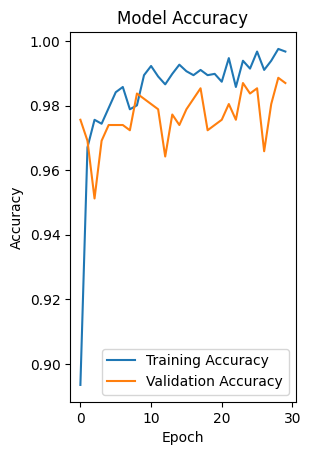

25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 336ms/step


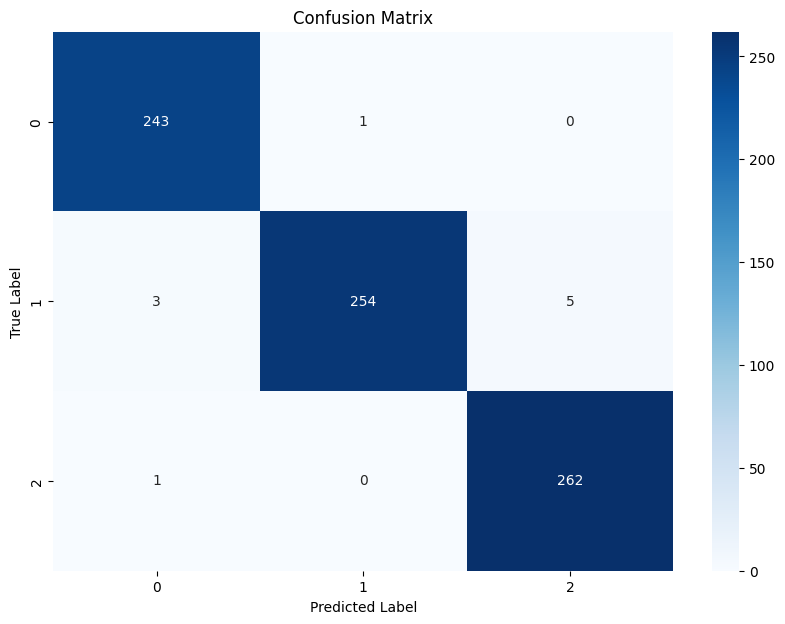

**********REPORT FOR  INCEPTIONV3  MODEL********** /n
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
              precision    recall  f1-score   support

       eagle       0.98      1.00      0.99       244
       panda       1.00      0.97      0.98       262
  polar-bear       0.98      1.00      0.99       263

    accuracy                           0.99       769
   macro avg       0.99      0.99      0.99       769
weighted avg       0.99      0.99      0.99       769

******************************************


In [8]:
import argparse
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import layers, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.models import load_model, Model
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


base_model = keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
    )
base_model.summary()

# Fine-tuning
#for layer in base_model.layers:
#    if layer.name == 'mixed7':
#        break
#   layer.trainable = False


#for layer in base_model.layers:
#    if layer.name == 'mixed7':
#        layer.trainable = True

  # Fine-tuning
for layer in base_model.layers[:310]:
       layer.trainable = False
for layer in base_model.layers[310:]:
       layer.trainable = True


x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.07)(x)
predictions = keras.layers.Dense(3, activation='softmax')(x)


inception_model = keras.models.Model(inputs=base_model.input, outputs=predictions)

inception_model.summary()
inception_model.compile(
optimizer=keras.optimizers.Adam(learning_rate= 0.00010549),
loss='sparse_categorical_crossentropy',
metrics=['accuracy']
)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12)
history = inception_model.fit(train_set, epochs=30, validation_data=val_set, callbacks=[stop_early])
inception_model.save('inception_model.h5')

# Evaluacija modela
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
test_set = test_datagen.flow(test_imgs, test_labels, batch_size=32, shuffle=False)
test_loss, test_accuracy = inception_model.evaluate(test_set)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

#Prikaz rezultata
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#Confusion matrica
test_predictions = inception_model.predict(test_imgs)
test_predictions = np.argmax(test_predictions, axis=1)  # Convert probabilities to class labels

conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

report_model(inception_model, "inceptionv3", test_imgs, test_labels, class_map)